In [1]:
%pip install textblob
%pip install --upgrade mplfinance
%pip install --upgrade transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.4 MB 16.9 MB/s eta 0:00:01
   ------ --------------------------------- 1.6/10.4 MB 5.2 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/10.4 MB 4.6 MB/s eta 0:00:02
   ------------ --------------------------- 3.1/10.4 MB 4.5 MB/s eta 0:00:02
   --------------- ------------------------ 3.9/10.4 MB 4.3 MB/s eta 0:00:02
   -------------------- ------------------- 5.2/10.4 MB 4.7 MB/s eta 0:00:02
   ---------------------- ----------------- 5.8/10.4 MB 4.4 MB/s eta 0:00:02
   ----------------------------- ---------- 7.6/10.4 MB 5.0 MB/s eta 0:00:01
   ------------------------------------- -- 9.7/10.4 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: tr

In [2]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input, Embedding
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
company_name = "AAPL"

def load_preprocessed_stock_data(file_path):
    df = pd.read_csv(file_path, sep="\t", header=None)
    df.columns = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    return df

def load_preprocessed_tweets(tweet_dir):
    tweet_data = {}
    for file in os.listdir(tweet_dir):
        file_path = os.path.join(tweet_dir, file)
        with open(file_path, "r", encoding="utf-8") as f:
            tweet_texts = []
            for line in f:
                try:
                    tweet_json = json.loads(line.strip())
                    tweet_texts.append(tweet_json.get("text", []))
                except json.JSONDecodeError as e:
                    print(f"Skipping malformed JSON in {file}: {e}")
            if tweet_texts:
                tweet_data[file] = tweet_texts
    return tweet_data

stock_data = load_preprocessed_stock_data(f"stocknet-dataset-master/price/preprocessed/{company_name}.txt")
tweets_data = load_preprocessed_tweets(f"stocknet-dataset-master/tweet/preprocessed/{company_name}")

print("Preprocessed Stock Data (First 5 Rows):")
print(stock_data.head())

print("\nPreprocessed Tweets (Sample Dates & Tweets):")
for date, texts in list(tweets_data.items())[:3]:
    print(f"{date}: {texts[:2]}")

Preprocessed Stock Data (First 5 Rows):
                Open      High       Low     Close  Adj Close      Volume
Date                                                                     
2017-09-01  0.000305  0.004878  0.005732 -0.002256   0.050003  16552800.0
2017-08-31  0.003979  0.001775  0.007163  0.000796   0.649994  26785100.0
2017-08-30  0.002701  0.005463  0.006016 -0.001842   0.440002  27269600.0
2017-08-29  0.008918 -0.008485  0.010219 -0.009104   1.440003  29516900.0
2017-08-28  0.010071  0.001752  0.013387  0.000438   1.610000  25966000.0

Preprocessed Tweets (Sample Dates & Tweets):
2014-01-01: [['rt', 'AT_USER', 'summary', 'of', "yesterday's", 'webcast', 'featuring', '$', 'aapl', '$', 'wynn', '$', 'goog', '$', 'lgf', 'tradereducation', 'options', 'hedgingstrategies', '-', '-', 'URL'], ['rt', 'AT_USER', 'summary', 'of', "yesterday's", 'webcast', 'featuring', '$', 'aapl', '$', 'wynn', '$', 'goog', '$', 'lgf', 'tradereducation', 'options', 'hedgingstrategies', '-', '-', 'UR

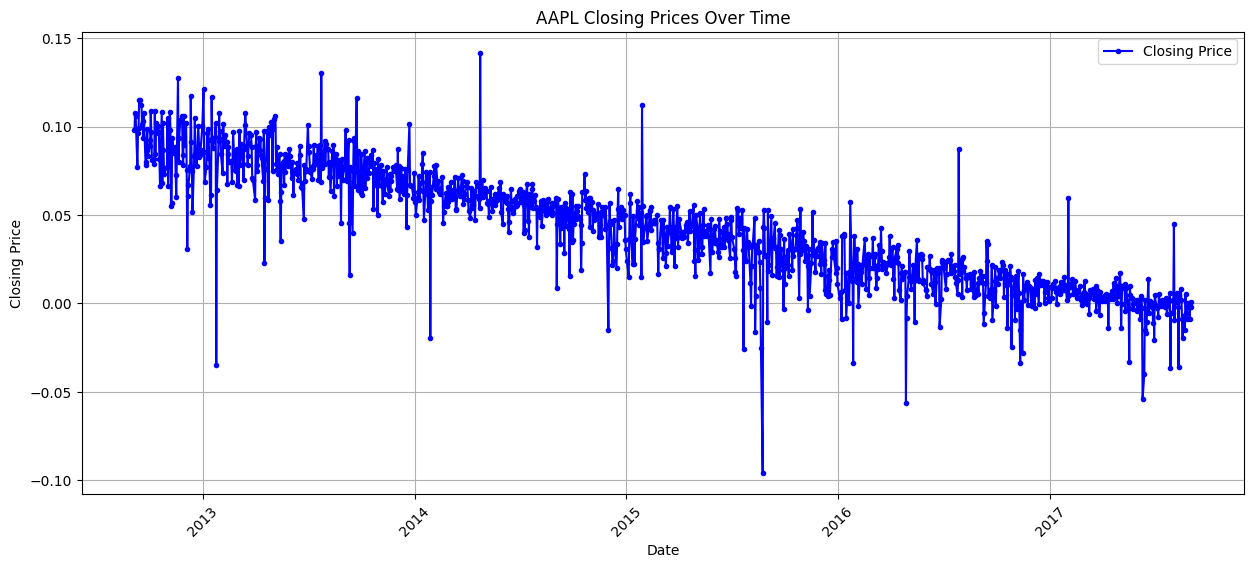

In [4]:
specific_df = stock_data.reset_index()

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.', label="Closing Price", color='blue')
plt.title(f'{company_name} Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

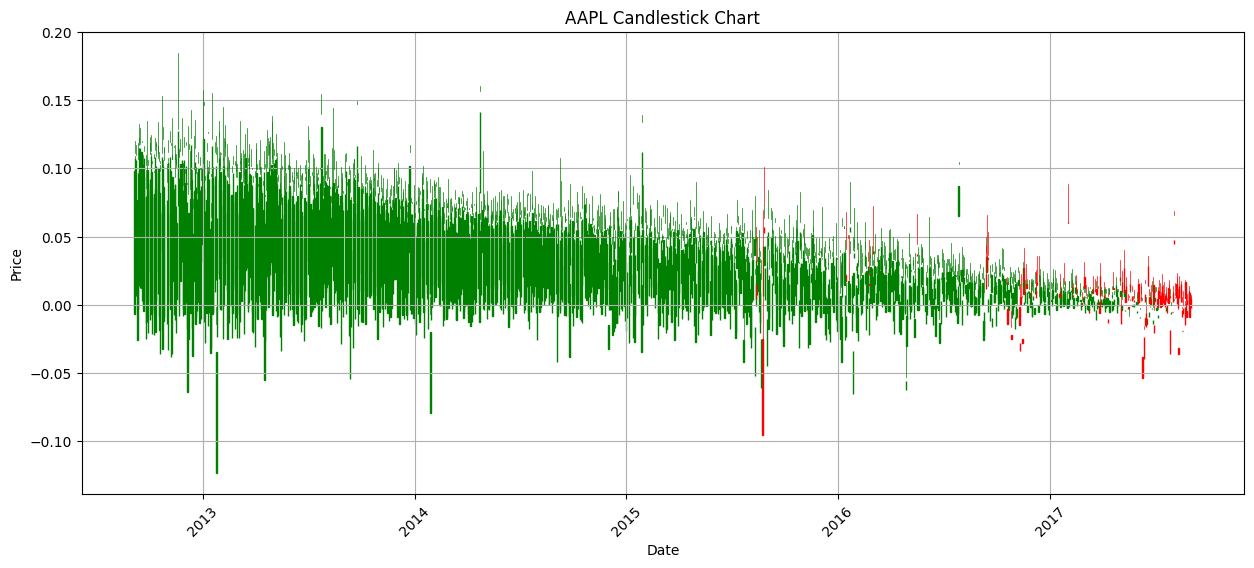

In [5]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])
specific_df['Date_Num'] = mdates.date2num(specific_df['Date'])
ohlc = specific_df[['Date_Num', 'Open', 'High', 'Low', 'Close']].values

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title(f'{company_name} Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

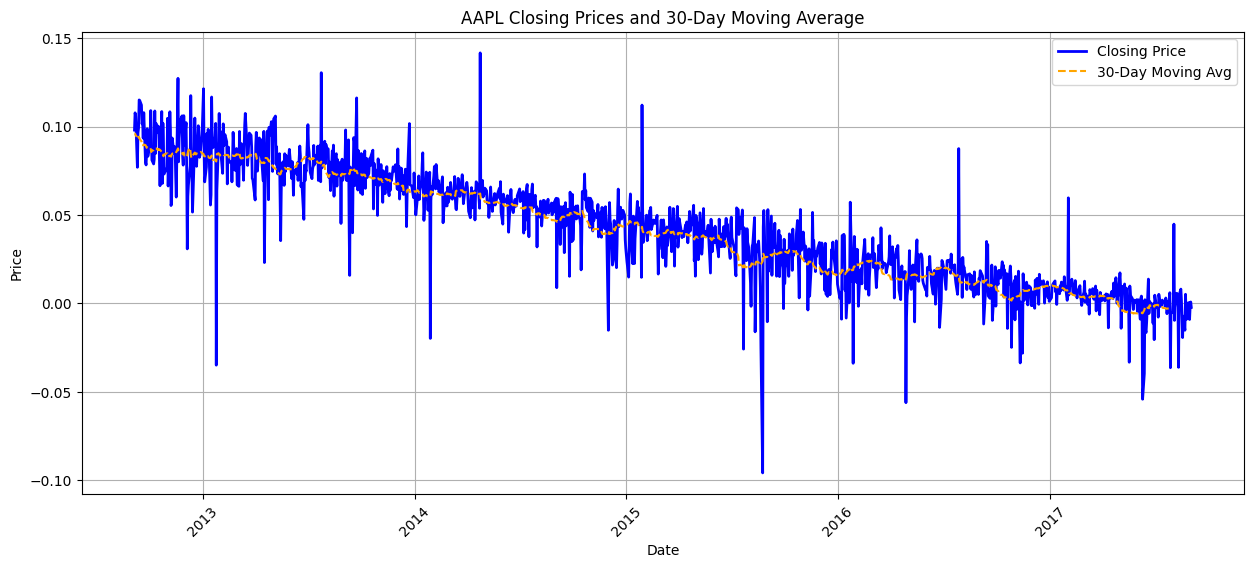

In [6]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Closing Price', linewidth=2, color='blue')
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(), 
         label=f'{window}-Day Moving Avg', linestyle='--', color='orange')
plt.title(f'{company_name} Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

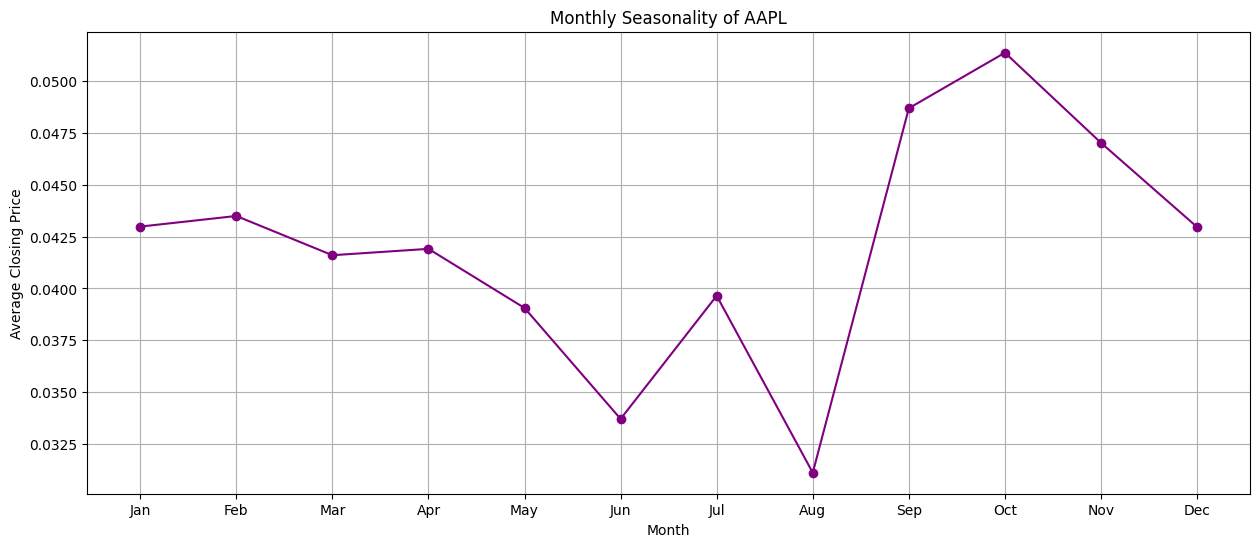

In [7]:
specific_df['Month'] = specific_df['Date'].dt.month
monthly_avg = specific_df.groupby('Month')['Close'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-', color='purple')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()